# Import Libraries & Dataset

In [1]:
# install and import libraries

!pip install transformers datasets accelerate -U
!pip install rapidfuzz
!pip install datasketch

import pandas as pd
import numpy as np
import re
import os
import torch
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score

from datasets import Dataset, DatasetDict
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler
from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from datasketch import MinHash, MinHashLSH
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

from google.colab import drive
from google.colab import files


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 4.2 MB/s eta 0:00:00


In [2]:
# load datasets 'True.csv' and 'Fake.csv' from google drive and concat them into a single dataframe 'df'

drive.mount('/content/drive')
for f in os.listdir():
    print(f)

df_false = pd.read_csv('/content/drive/MyDrive/Fake.csv')
df_true = pd.read_csv('/content/drive/MyDrive/True.csv')

df_false["label"] = 0
df_true["label"] = 1

df = pd.concat([df_true, df_false], axis=0).reset_index(drop=True)

Mounted at /content/drive
.config
drive
sample_data


## Analyze & Clean Data

Dataset Shape: (44898, 5)

Label Counts:
label
0    23481
1    21417
Name: count, dtype: int64


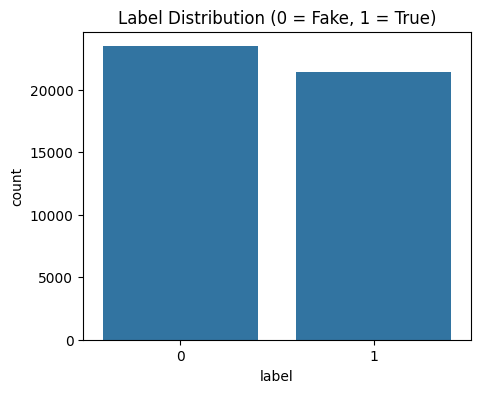

In [3]:
# analyze shape and label

print("Dataset Shape:", df.shape)
print("\nLabel Counts:")
print(df["label"].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(data=df, x="label")
plt.title("Label Distribution (0 = Fake, 1 = True)")
plt.show()

In [4]:
# analyze sample content

print("📰 True articles:")
print(df[df["label"] == 1].head(10))

print("\n🧾 False articles:")
print(df[df["label"] == 0].head(10))

📰 True articles:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   
7  Factbox: Trump on Twitter (Dec 29) - Approval ...   
8         Trump on Twitter (Dec 28) - Global Warming   
9  Alabama official to certify Senator-elect Jone...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHI

In [5]:
# check rows for any missing values

print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [title, text, subject, date, label]
Index: []


In [6]:
# print the unique values & their counts for column 'subject'

subject_label_counts = df.groupby(['subject', 'label']).size()
print(subject_label_counts)

subject          label
Government News  0         1570
Middle-east      0          778
News             0         9050
US_News          0          783
left-news        0         4459
politics         0         6841
politicsNews     1        11272
worldnews        1        10145
dtype: int64


In [7]:
# drop 'left-news' in Fake column as it doesn't have an equivalent in True columns and could learn bias

df = df[df['subject'] != 'left-news']
print(df['subject'].value_counts())

# drop 'subject' and 'date' columns as they don't carry significant information

df = df.drop(columns=['subject', 'date'])
print(df.columns.tolist())

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64
['title', 'text', 'label']


In [8]:
# convert text in columns 'text' and 'title' to lowercase

df['text'] = df['text'].str.lower()
df['title'] = df['title'].str.lower()

In [10]:
# find word count metrics for text and title based on label

df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))

print(df.groupby('label')['text_length'].describe())
print(df.groupby('label')['title_length'].describe())


         count        mean         std  min    25%    50%    75%     max
label                                                                   
0      19022.0  430.338503  417.925202  0.0  257.0  371.0  505.0  8135.0
1      21417.0  385.640099  274.006204  0.0  148.0  359.0  525.0  5172.0
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      19022.0  14.190727  3.975359  1.0  12.0  14.0  16.0  42.0
1      21417.0   9.954475  1.700747  4.0   9.0  10.0  11.0  20.0


In [12]:
# remove any articles that only contain whitespaces
df = df[df['text'].str.strip() != '']
df = df[df['title'].str.strip() != '']

In [13]:
# remove outlier articles (based on word count)

# obtain q1 and q3 text lengths
q1_text = df['text_length'].quantile(0.25)
q3_text = df['text_length'].quantile(0.75)
iqr_text = q3_text - q1_text

q1_title = df['title_length'].quantile(0.25)
q3_title = df['title_length'].quantile(0.75)
iqr_title = q3_title - q1_title

# keep only articles within 1.5*IQR from q1 and q3
df = df[(df['text_length'] >= q1_text - 1.5*iqr_text) & (df['text_length'] <= q3_text + 1.5*iqr_text)]
df = df[(df['title_length'] >= q1_title - 1.5*iqr_title) & (df['title_length'] <= q3_title + 1.5*iqr_title)]

# remove any articles with less than 50 words in text
df = df[(df['text_length'] >= 50)]

In [14]:
# analyze change

print(df.groupby('label')['text_length'].describe())
print(df.groupby('label')['title_length'].describe())

         count        mean         std   min    25%    50%    75%    max
label                                                                   
0      15936.0  396.744603  172.155638  50.0  292.0  377.0  493.0  969.0
1      20426.0  366.006854  232.142314  50.0  153.0  354.0  502.0  969.0
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      15936.0  13.619980  3.011208  4.0  12.0  14.0  16.0  21.0
1      20426.0   9.949917  1.690636  4.0   9.0  10.0  11.0  20.0


In [16]:
# download stopwords from library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# clean text function
def full_clean_text(text):
    if not isinstance(text, str):
        return ""

    # remove anything before "(Reuters) - "
    text = re.sub(r"^.*?(?:\(Reuters\)|Reuters)\s*-\s*", "", text, flags=re.IGNORECASE)

    # fix encoding artifacts
    try:
        text = text.encode('latin1').decode('utf-8')
    except:
        pass

    # remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # remove month names and numbers
    text = re.sub(
    r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|'
    r'january|february|march|april|may|june|july|august|september|october|november|december)\b\.?',
    '',
    text,
    flags=re.IGNORECASE
    )
    text = re.sub(r'\d+', '', text)


    # remove stopwords
    words = text.split()
    words = [w for w in words if w.lower() not in stop_words]
    text = " ".join(words)

    # remove weird symbols
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"-]', ' ', text)

    # get rid of multiple whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# apply to both text and title
df['text'] = df['text'].apply(full_clean_text)
df['title'] = df['title'].apply(full_clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
# print column count prior to duplicate and near duplicate removal
print(df.shape)

# remove duplicates
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)


# break text into shingles

shingle_size = 7                    # num of words per shingle
num_perm = 256                      # num of permutations for MinHash
similarity_threshold = 0.85         # MinHash similarity threshold for near-duplicates

def get_shingles(text, k=shingle_size):
    words = text.split()
    shingles = set()
    for i in range(max(len(words) - k + 1, 1)):
        shingles.add(" ".join(words[i:i+k]))
    return shingles


# remove near duplicates
def remove_near_duplicates(df, text_column="text"):
    lsh = MinHashLSH(threshold=similarity_threshold, num_perm=num_perm)
    minhashes = {}
    for idx, text in enumerate(df[text_column]):
        shingles = get_shingles(text)
        m = MinHash(num_perm=num_perm)
        for shingle in shingles:
            m.update(shingle.encode('utf8'))
        minhashes[idx] = m
        lsh.insert(idx, m)
    to_drop = set()
    for idx, m in minhashes.items():
        if idx in to_drop:
            continue
        result = lsh.query(m)
        for j in result:
            if j != idx:
                to_drop.add(j)
    df_cleaned = df.drop(list(to_drop)).reset_index(drop=True)
    return df_cleaned


# update df to clean ver
df = remove_near_duplicates(df, text_column="text")


# print column count after duplicate and near duplicate cleaning
print(df.shape)

(34801, 5)
(34751, 5)


In [22]:
# Count how many articles are true and fake
print(df['label'].value_counts())

label
1    20184
0    14567
Name: count, dtype: int64


In [23]:
# print samples of current state of dataset
print("📰 True articles:")
print(df[df["label"] == 1].head(10))

print("\n🧾 False articles:")
print(df[df["label"] == 0].head(10))

📰 True articles:
                                               title  \
0  u.s. budget fight looms, republicans flip fisc...   
1  u.s. military accept transgender recruits mond...   
2  senior u.s. republican senator 'let mr. muelle...   
3  fbi russia probe helped australian diplomat ti...   
4  trump wants postal service charge 'much more' ...   
5  white house, congress prepare talks spending, ...   
6  trump says russia probe fair, timeline unclear...   
7    factbox trump twitter - approval rating, amazon   
8                     trump twitter - global warming   
9  alabama official certify senator-elect jones t...   

                                                text  label  text_length  \
0  head conservative republican faction u.s. cong...      1          749   
1  transgender people allowed first time enlist u...      1          624   
2  special counsel investigation links russia pre...      1          457   
3  trump campaign adviser george papadopoulos tol...      1   

In [24]:
# combine text and title columns into one
df['title_and_text'] = " [TITLE] " + df['title'] + " [ARTICLE] " + df['text']

X = df['title_and_text']
y = df['label']

# drop all other columns besides 'title_and_text' and 'label'
df.drop(columns = ['title', 'text', 'text_length', 'title_length'], inplace=True)


In [25]:
# download clean dataset as csv file

from google.colab import files
df.to_csv('cleaned_articles.csv', index=False)
files.download('cleaned_articles.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TRAINING DATA

In [26]:
# load model
model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# create a hugging face dataset

ds = Dataset.from_pandas(df)
ds = ds.rename_column("label", "labels")

# tokenize function

def tokenize_function(x):
  return tokenizer(x['title_and_text'], padding='max_length', truncation=True, max_length=512)

tokenized_ds = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/34751 [00:00<?, ? examples/s]

In [28]:
# split tokenized dataset into training and test set

dds = tokenized_ds.train_test_split(test_size=0.25, seed=123)
train_ds = dds['train']
eval_ds = dds['test']

In [29]:
# declare and initialize hyperparameters

batch_size = 16
epochs = 1
learning_rate = 1e-5

In [30]:
# set training configuration

args = TrainingArguments(
    output_dir='outputs',
    learning_rate=learning_rate,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    eval_strategy='epoch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size*2,
    num_train_epochs=epochs,
    weight_decay=0.3,
    report_to='none',
)

In [31]:
# function for computing evaluation metrics

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # turn model outputs into class predictions and probabilities
    if predictions.ndim > 1 and predictions.shape[1] > 1:
        exp_preds = np.exp(predictions)
        probs = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)
        preds = np.argmax(predictions, axis=1)
        pos_probs = probs[:, 1]
    else:
        preds = (predictions > 0.5).astype(int)
        pos_probs = predictions

    # compute metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)

    try:
        roc_auc = roc_auc_score(labels, pos_probs)
    except ValueError:
        roc_auc = float('nan')

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc
    }


In [32]:
# train model

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# get metrics from trainer

metrics = trainer.evaluate()
print(metrics)

/tmp/ipython-input-1312218346.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.002600,0.006294,0.998619,0.998815,0.998026,0.999605,0.999996


{'eval_loss': 0.006294344086199999, 'eval_accuracy': 0.9986187845303868, 'eval_f1': 0.9988146977479258, 'eval_precision': 0.9980260560600079, 'eval_recall': 0.9996045867931989, 'eval_roc_auc': 0.9999957245266207, 'eval_runtime': 93.4788, 'eval_samples_per_second': 92.941, 'eval_steps_per_second': 2.91, 'epoch': 1.0}


# **Trust Score Calculation**

In [33]:
pred_output = trainer.predict(eval_ds)
logits = pred_output.predictions
true_labels = pred_output.label_ids

probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
trust_scores = probs[:, 1]              # P(label=1)
pred_labels = np.argmax(logits, axis=1)
trust_scores_rounded = np.round(trust_scores, 4)

deberta_predictions_df = pd.DataFrame({
    "True Label": true_labels,
    "Predicted Label": pred_labels,
    "Trust Score": trust_scores_rounded
})

print(deberta_predictions_df.head(10))

   True Label  Predicted Label  Trust Score
0           0                0       0.0001
1           0                0       0.0001
2           1                1       0.9999
3           0                0       0.0001
4           0                0       0.0001
5           1                1       0.9999
6           0                0       0.0001
7           0                0       0.0001
8           1                1       0.9999
9           0                0       0.0001


# **Visuals & Evals**

In [42]:
# get predictions for plotting

pred_output = trainer.predict(eval_ds)
pred_logits = pred_output.predictions
true_labels = pred_output.label_ids

# softmax to get probabilities
probs = torch.softmax(torch.tensor(pred_logits), dim=1).numpy()
pos_probs = probs[:, 1]

# convert logits → predicted class
pred_classes = np.argmax(pred_logits, axis=1)

# metrics already computed
print("Eval Metrics:", metrics)


Eval Metrics: {'eval_loss': 0.006294344086199999, 'eval_accuracy': 0.9986187845303868, 'eval_f1': 0.9988146977479258, 'eval_precision': 0.9980260560600079, 'eval_recall': 0.9996045867931989, 'eval_roc_auc': 0.9999957245266207, 'eval_runtime': 93.4788, 'eval_samples_per_second': 92.941, 'eval_steps_per_second': 2.91, 'epoch': 1.0}


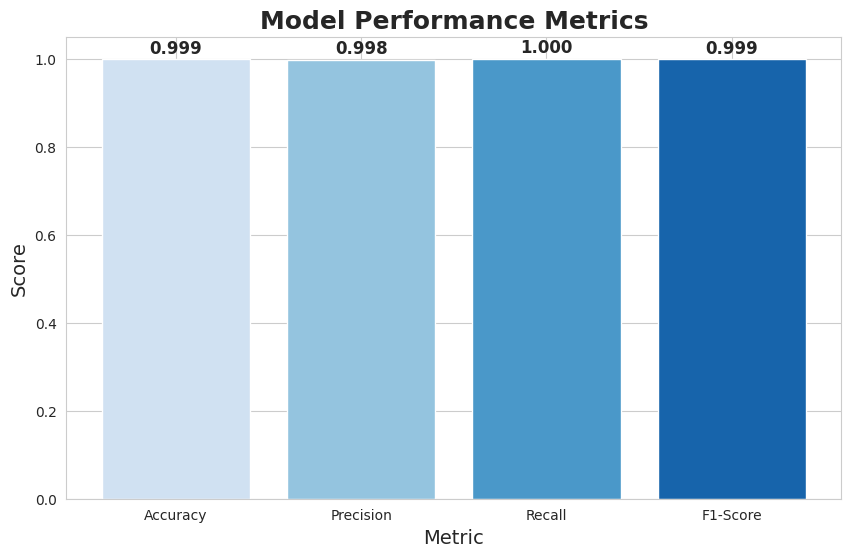

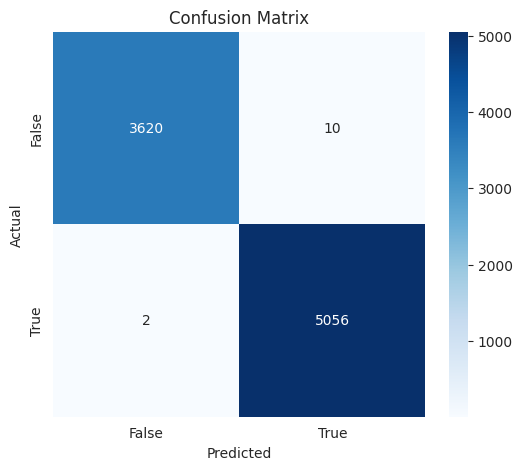

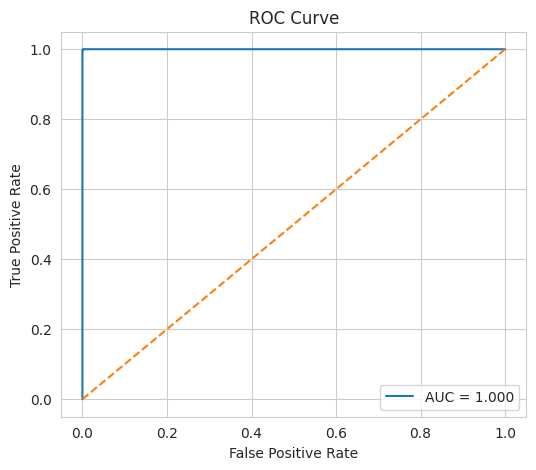

In [43]:
# accuracy, precision, recall, f1

# extract metrics from trainer.evaluate()
accuracy = metrics["eval_accuracy"]
precision = metrics["eval_precision"]
recall = metrics["eval_recall"]
f1 = metrics["eval_f1"]

# metric names and values
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]
metric_values = [accuracy, precision, recall, f1]

colors = sns.color_palette("Blues", len(metric_values))

# plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

bars = plt.bar(metric_names, metric_values, color=colors)

# add value labels above each bar
for bar, value in zip(bars, metric_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f"{value:.3f}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

# title and labels
plt.title("Model Performance Metrics", fontsize=18, fontweight='bold')
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.ylim(0, 1.05)

plt.show()

# confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["False", "True"],
            yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# roc curve

fpr, tpr, thresholds = roc_curve(true_labels, pos_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [44]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# saving the finetuned model and tokenizer

# define the path where the finetuned model and tokenizer will be saved
clean_path = "/content/drive/MyDrive/my_finetuned_deberta_clean"

# create the directory if it doesn't exist
if not os.path.exists(clean_path):
    os.makedirs(clean_path)

# save the finetuned model using the trainer
# the 'trainer' and 'tokenizer' objects are available from previous cells after training.
trainer.save_model(clean_path)
tokenizer.save_pretrained(clean_path)

print(f"Saved finetuned model and tokenizer to: {clean_path}")

Saved finetuned model and tokenizer to: /content/drive/MyDrive/my_finetuned_deberta_clean


In [46]:
os.listdir("/content/drive/MyDrive/my_finetuned_deberta_clean")

['config.json',
 'model.safetensors',
 'tokenizer_config.json',
 'special_tokens_map.json',
 'added_tokens.json',
 'spm.model',
 'tokenizer.json',
 'training_args.bin']